# Analyze Individual P-PO and O-PO Alignments

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os.path
import IPython.display as ipd
import import_ipynb
import system_utils
from pathlib import Path
import eval_tools

In [26]:
annot_path = Path('annot')
scenarios_path = Path('scenarios')

We only have beat annotations for some of the PO beat files (see `annot/`).

In [27]:
po_beat_files = ['bach5_mov1_PO2.beat', 'beeth1_mov1_PO1.beat', 'mozart21_mov1_PO2.beats', 'rach2_mov1_PO2.beats']

po_beat_files = [annot_path / f for f in po_beat_files]
po_beat_filenames = [f.stem for f in po_beat_files]

In [28]:
scenarios = system_utils.get_scenario_info('scenarios/scenarios.summary')

Filter out scenarios that don't have beat annotations.

In [29]:
filtered_scenarios = {}

for k, v in scenarios.items():
    if Path(v['po']).stem in po_beat_filenames:
        filtered_scenarios[k] = v

In [30]:
systems_to_compare = ['offlineDTW', 'match', 'separatedMatch_SPL-PT', 'separatedMatch_HDemucs', 'separatedMatch_SPL-TTA', 'ISA_CHROMA']
eval_dirs = [Path('experiments')/s for s in systems_to_compare]

In [31]:
eval_results = {}

for eval_dir in eval_dirs:
    system_results = {
        "p-po": {},
        "o-po": {}
    }
    
    for scenario_id, scenario_info in filtered_scenarios.items():
        frames = False
        align_offset = 0.0
        if eval_dir.stem in ['ISA_CHROMA', 'offlineDTW']:
            frames = True

        po_file_name = Path(scenario_info['po']).stem
        
        system_results['p-po'][scenario_id] = eval_tools.calcAlignErrors_single(
            eval_dir/scenario_id/'p_po_align.npy',
            scenarios_path/scenario_id/'p.beats',
            annot_path/(po_file_name + ".beats"),
            scenarios_path/scenario_id/'scenario.info',
            frames=frames
        )

        o_po_folder_name = po_file_name[:po_file_name.find('_PO')] + '_O1_PO' + po_file_name[po_file_name.find('_PO') + 3:]
        system_results['o-po'][scenario_id] = eval_tools.calcAlignErrors_single(
            eval_dir/'cache'/o_po_folder_name/'o_po_align.npy',
            scenarios_path/scenario_id/'o.beats',
            annot_path/(po_file_name + ".beats"),
            scenarios_path/scenario_id/'scenario.info',
            frames=True
        )
    
    eval_results[eval_dir.stem] = system_results

In [32]:
eval_results['match']['o-po']['s79']

(array([ 4.32879820e-02, -4.52154194e-01,  5.80045339e-02,  6.16780042e-02,
        -4.35124716e-01, -1.39452381e+00,  1.12848073e+00,  3.28401361e-01,
        -7.85487533e-02, -7.54648518e-02,  1.80249433e-01, -7.16439911e-02,
        -1.39841269e-01,  4.03174602e-02,  6.70272109e-01,  2.36734685e-02,
         2.30612245e-01,  8.94897958e-02,  1.55192744e-01, -7.39229069e-03,
        -1.57596377e-02, -1.22539682e-01,  2.44648526e-01,  4.78276645e-01,
         2.83764172e-01,  1.08163266e-01, -1.35147396e-02,  7.88752835e-01,
        -6.34920628e-03, -4.10793651e-01,  2.51337868e-01,  1.57369605e-02,
         3.54648526e-02,  1.93650797e-02, -1.51133788e-02,  2.82539684e-02,
         2.21315192e-02, -3.84126986e-02, -2.16575965e-01, -1.95691610e-01,
         8.80306122e-01,  6.71768704e-02,  9.70521553e-02, -6.17233553e-02,
         2.46405896e-01,  5.71428526e-03, -2.16780045e-02, -6.04081628e-02,
        -7.21088434e-03,  2.71655332e-02, -1.80498862e-02, -2.32199549e-02,
        -2.7

In [91]:
def plot_p_vs_po_alignment(eval_results, savefile=None, mainTol=200, maxTol=500, minTol=100):
    bar_width = 0.1

    for i, system in enumerate(eval_results.keys()):
        # p vs. po alignment
        p_errs = np.array([])
        for scenario_id in eval_results[system]['p-po'].keys():
            p_errs = np.concatenate((p_errs, eval_results[system]['p-po'][scenario_id][0]))

        p_errRates = np.zeros(maxTol+1)
        p_tols = np.arange(maxTol+1)

        p_errs = np.abs(p_errs)
        
        for j in p_tols:
            p_errRates[j] = np.mean(np.abs(p_errs) > j/1000)


        # o vs. po alignment
        o_errs = []
        for scenario_id in eval_results[system]['o-po'].keys():
            o_errs = np.concatenate((o_errs, eval_results[system]['o-po'][scenario_id][0]))

        o_errRates = np.zeros(maxTol+1)
        o_tols = np.arange(maxTol+1)

        o_errs = np.abs(o_errs)
        
        for j in o_tols:
            o_errRates[j] = np.mean(np.abs(o_errs) > j/1000)
        
        errs = np.array([p_errRates[mainTol], o_errRates[mainTol]]) * 100
        pos = np.array([0, 1]) + i * bar_width

        err_tol = [
            [p_errRates[minTol], o_errRates[minTol]],
            [p_errRates[maxTol], o_errRates[maxTol]]
        ]
        err_tol = np.array(err_tol) * 100

        plt.bar(pos, errs, bar_width, label=system, zorder=10)
        plt.scatter(pos, err_tol[0], c='black', s=20, zorder=10, label='_nolegend_')
        plt.scatter(pos, err_tol[1], c='black', s=20, zorder=10, label='_nolegend_')
        plt.plot([pos[0], pos[0]], err_tol[:,0], c='black', zorder=10, label='_nolegend_')
        plt.plot([pos[1], pos[1]], err_tol[:,1], c='black', zorder=10, label='_nolegend_')
        plt.xticks([r + bar_width*len(eval_results.keys())/2 for r in range(2)], ['p-po', 'o-po'])
        
    plt.ylabel('Error Rate (%)')
    plt.xlabel('Error Tolerance (ms)')
    plt.legend([os.path.basename(eval_dir) for eval_dir in eval_dirs], loc=(1.04, 0))
    plt.grid(linestyle='--', zorder=-1.0, axis='y')
    if savefile:
        plt.savefig(savefile)

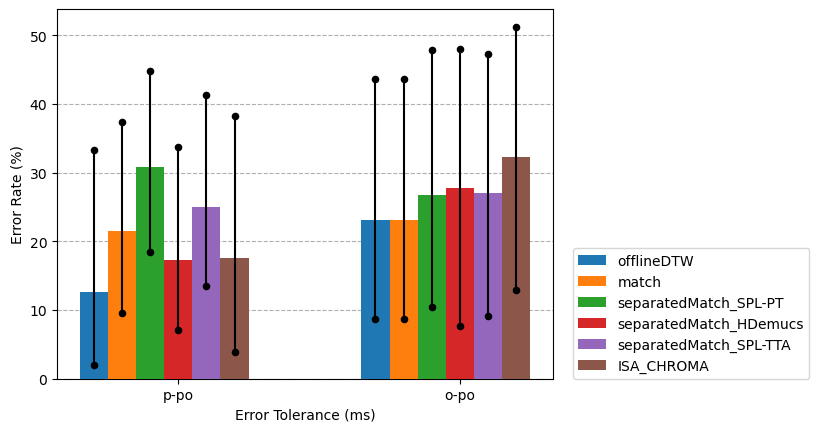

In [92]:
plot_p_vs_po_alignment(eval_results, minTol=100, mainTol=200, maxTol=500)